# Forecasting financial time series with dynamic deep learning: A combo RNN architecture with GRUs and covariates compared to ARIMAx and DeepAR              


## Import packages and define session

In [77]:
# Import everything needed for this session to develop and evaluate the RNN combo designed in train file
import boto3, s3fs
import re, os, json
import numpy as np
import pandas as pd
from io import StringIO
import sagemaker as sage
import matplotlib as mpl
import matplotlib.pyplot as plt
from time import gmtime, strftime
from statsmodels.tsa.stattools import acf, pacf
from sagemaker.predictor import csv_serializer
from sagemaker import get_execution_role

# Define IAM role and session
role = get_execution_role()
sess = sage.Session()

## Upload data and define model image

In [78]:
# Upload directory with data files on daily stock values and top news headlines 
data_location = sess.upload_data('./inputdata', key_prefix='data')

# Define model artifact name and image
account = sess.boto_session.client('sts').get_caller_identity()['Account']
region = sess.boto_session.region_name
artifactname = 'rnn-forecast009'
image = '{}.dkr.ecr.{}.amazonaws.com/{}'.format(account, region, artifactname)


INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-452477717799


## Build and push Docker container on ECS

In [79]:
%%sh

# Name artifact
artifactname=rnn-forecast009

# Build and push the container
cd container
chmod +x rnn/serve
chmod +x rnn/train
chmod u+x build_and_push.sh
./build_and_push.sh $artifactname

Login Succeeded

Step 1/9 : FROM ubuntu:16.04
 ---> f975c5035748
Step 2/9 : MAINTAINER Amazon AI <sage-learner@amazon.com>
 ---> Using cache
 ---> 1c403bf931a3
Step 3/9 : RUN apt-get -y update && apt-get install -y --no-install-recommends          wget          python          nginx          ca-certificates     && rm -rf /var/lib/apt/lists/*
 ---> Using cache
 ---> 54aff9ba0378
Step 4/9 : RUN wget https://bootstrap.pypa.io/get-pip.py && python get-pip.py &&     pip install numpy scipy scikit-learn pandas flask gevent gunicorn keras tensorflow theano h5py textblob
 ---> Using cache
 ---> e2cf555147db
Step 5/9 : ENV PYTHONUNBUFFERED=TRUE
 ---> Using cache
 ---> 694bbf80e51e
Step 6/9 : ENV PYTHONDONTWRITEBYTECODE=TRUE
 ---> Using cache
 ---> 76ab5ff77959
Step 7/9 : ENV PATH="/opt/program:${PATH}"
 ---> Using cache
 ---> cddf80f39f29
Step 8/9 : COPY rnn /opt/program
 ---> 9edab3943433
Step 9/9 : WORKDIR /opt/program
Removing intermediate container bab8c7d5e991
 ---> fdbb83a01cde
Successful

WARNING! Using --password via the CLI is insecure. Use --password-stdin.


## Train the model

In [80]:
# Instantiate estimator with container image of artifact and backend EC2 instance(s)  
rnn = sage.estimator.Estimator(image,
                       role, 1, 'ml.c4.2xlarge',
                       output_path="s3://{}/output".format(sess.default_bucket()),
                       sagemaker_session=sess)
# Train the model
rnn.fit(data_location)

INFO:sagemaker:Creating training-job with name: rnn-forecast009-2018-07-26-23-33-55-313


..............................
/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
Training path:  /opt/ml/input/data/training
Input file(s):  ['prices-split-adjusted.csv', 'stockprices.csv', 'Combined_News_DJIA.csv']
Starting the training.
Rescaling  STOCKA
Rescaling  open
Rescaling  low
Rescaling  high
Rescaling  volume
Rescaling  adjclose
Rescaling  STOCKB
/opt/program/train:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  train_exo1["s"] = news.s
/opt/program/train:182: SettingWithCop

1557/1557 [==============================] - 2s 1ms/step - loss: 0.6630 - main_out_loss: 0.6631 - combo_out_loss: 0.6623
Epoch 5/100

1557/1557 [==============================] - 2s 1ms/step - loss: 0.6624 - main_out_loss: 0.6629 - combo_out_loss: 0.6608
Epoch 6/100

1557/1557 [==============================] - 2s 1ms/step - loss: 0.6624 - main_out_loss: 0.6628 - combo_out_loss: 0.6606
Epoch 7/100

 352/1557 [=====>........................] - ETA: 1s - loss: 0.6653 - main_out_loss: 0.6659 - combo_out_loss: 0.6628


1557/1557 [==============================] - 2s 1ms/step - loss: 0.6616 - main_out_loss: 0.6624 - combo_out_loss: 0.6584
Epoch 8/100

1557/1557 [==============================] - 2s 1ms/step - loss: 0.6610 - main_out_loss: 0.6621 - combo_out_loss: 0.6562
Epoch 9/100

1557/1557 [==============================] - 2s 1ms/step - loss: 0.6610 - main_out_loss: 0.6628 - combo_out_loss: 0.6539
Epoch 10/100

1557/1557 [==============================] - 2s 1ms/step - loss: 0.6596 - main_out_loss: 0.6615 - combo_out_loss: 0.6520
Epoch 11/100

1557/1557 [==============================] - 2s 1ms/step - loss: 0.6589 - main_out_loss: 0.6612 - combo_out_loss: 0.6495
Epoch 12/100

 864/1557 [===============>..............] - ETA: 0s - loss: 0.6545 - main_out_loss: 0.6574 - combo_out_loss: 0.6428


1557/1557 [==============================] - 2s 1ms/step - loss: 0.6568 - main_out_loss: 0.6596 - combo_out_loss: 0.6452
Epoch 13/100

1557/1557 [==============================] - 2s 1ms/step - loss: 0.6543 - main_out_loss: 0.6577 - combo_out_loss: 0.6408
Epoch 14/100

1557/1557 [==============================] - 2s 1ms/step - loss: 0.6530 - main_out_loss: 0.6566 - combo_out_loss: 0.6386
Epoch 15/100

1557/1557 [==============================] - 2s 1ms/step - loss: 0.6510 - main_out_loss: 0.6552 - combo_out_loss: 0.6342
Epoch 16/100

1557/1557 [==============================] - 2s 1ms/step - loss: 0.6479 - main_out_loss: 0.6531 - combo_out_loss: 0.6274
Epoch 17/100

1376/1557 [=========================>....] - ETA: 0s - loss: 0.6481 - main_out_loss: 0.6534 - combo_out_loss: 0.6271


1557/1557 [==============================] - 2s 1ms/step - loss: 0.6453 - main_out_loss: 0.6508 - combo_out_loss: 0.6234
Epoch 18/100

1557/1557 [==============================] - 2s 1ms/step - loss: 0.6406 - main_out_loss: 0.6467 - combo_out_loss: 0.6159
Epoch 19/100

1557/1557 [==============================] - 2s 1ms/step - loss: 0.6382 - main_out_loss: 0.6438 - combo_out_loss: 0.6161
Epoch 20/100

1557/1557 [==============================] - 2s 1ms/step - loss: 0.6363 - main_out_loss: 0.6435 - combo_out_loss: 0.6074
Epoch 21/100

1557/1557 [==============================] - 2s 1ms/step - loss: 0.6329 - main_out_loss: 0.6409 - combo_out_loss: 0.6008
Epoch 22/100

1557/1557 [==============================] - 2s 1ms/step - loss: 0.6278 - main_out_loss: 0.6360 - combo_out_loss: 0.5953
Epoch 23/100

 352/1557 [=====>........................] - ETA: 1s - loss: 0.6279 - main_out_loss: 0.6375 - combo_out_loss: 0.5894


1557/1557 [==============================] - 2s 1ms/step - loss: 0.6266 - main_out_loss: 0.6369 - combo_out_loss: 0.5853
Epoch 24/100

1557/1557 [==============================] - 2s 1ms/step - loss: 0.6188 - main_out_loss: 0.6285 - combo_out_loss: 0.5800
Epoch 25/100

1557/1557 [==============================] - 2s 1ms/step - loss: 0.6122 - main_out_loss: 0.6233 - combo_out_loss: 0.5677
Epoch 26/100

1557/1557 [==============================] - 2s 1ms/step - loss: 0.6120 - main_out_loss: 0.6245 - combo_out_loss: 0.5620
Epoch 27/100

1557/1557 [==============================] - 2s 1ms/step - loss: 0.6036 - main_out_loss: 0.6173 - combo_out_loss: 0.5488
Epoch 28/100

 928/1557 [================>.............] - ETA: 0s - loss: 0.5969 - main_out_loss: 0.6106 - combo_out_loss: 0.5421


1557/1557 [==============================] - 2s 1ms/step - loss: 0.5992 - main_out_loss: 0.6124 - combo_out_loss: 0.5462
Epoch 29/100

1557/1557 [==============================] - 2s 1ms/step - loss: 0.5889 - main_out_loss: 0.6031 - combo_out_loss: 0.5320
Epoch 30/100

1557/1557 [==============================] - 2s 1ms/step - loss: 0.5857 - main_out_loss: 0.6019 - combo_out_loss: 0.5210
Epoch 31/100

1557/1557 [==============================] - 2s 1ms/step - loss: 0.5756 - main_out_loss: 0.5926 - combo_out_loss: 0.5074
Epoch 32/100

1557/1557 [==============================] - 2s 1ms/step - loss: 0.5721 - main_out_loss: 0.5898 - combo_out_loss: 0.5014
Epoch 33/100

1440/1557 [==========================>...] - ETA: 0s - loss: 0.5573 - main_out_loss: 0.5776 - combo_out_loss: 0.4760


1557/1557 [==============================] - 2s 1ms/step - loss: 0.5597 - main_out_loss: 0.5805 - combo_out_loss: 0.4767
Epoch 34/100

1557/1557 [==============================] - 2s 1ms/step - loss: 0.5521 - main_out_loss: 0.5734 - combo_out_loss: 0.4669
Epoch 35/100

1557/1557 [==============================] - 2s 1ms/step - loss: 0.5477 - main_out_loss: 0.5711 - combo_out_loss: 0.4542
Epoch 36/100

1557/1557 [==============================] - 2s 1ms/step - loss: 0.5372 - main_out_loss: 0.5607 - combo_out_loss: 0.4429
Epoch 37/100

1557/1557 [==============================] - 2s 1ms/step - loss: 0.5270 - main_out_loss: 0.5515 - combo_out_loss: 0.4290
Epoch 38/100

1557/1557 [==============================] - 2s 1ms/step - loss: 0.5181 - main_out_loss: 0.5435 - combo_out_loss: 0.4165
Epoch 39/100

 416/1557 [=======>......................] - ETA: 1s - loss: 0.5186 - main_out_loss: 0.5485 - combo_out_loss: 0.3992


1557/1557 [==============================] - 2s 1ms/step - loss: 0.5139 - main_out_loss: 0.5413 - combo_out_loss: 0.4040
Epoch 40/100

1557/1557 [==============================] - 2s 1ms/step - loss: 0.4968 - main_out_loss: 0.5235 - combo_out_loss: 0.3900
Epoch 41/100

1557/1557 [==============================] - 2s 1ms/step - loss: 0.4953 - main_out_loss: 0.5236 - combo_out_loss: 0.3819
Epoch 42/100


1557/1557 [==============================] - 2s 1ms/step - loss: 0.4877 - main_out_loss: 0.5156 - combo_out_loss: 0.3759
Epoch 43/100

1557/1557 [==============================] - 2s 1ms/step - loss: 0.4746 - main_out_loss: 0.5012 - combo_out_loss: 0.3680
Epoch 44/100

1557/1557 [==============================] - 2s 1ms/step - loss: 0.4763 - main_out_loss: 0.5042 - combo_out_loss: 0.3647
Epoch 45/100

1557/1557 [==============================] - 2s 1ms/step - loss: 0.4582 - main_out_loss: 0.4852 - combo_out_loss: 0.3499
Epoch 46/100

1557/1557 [==============================] - 2s 1ms/step - loss: 0.4503 - main_out_loss: 0.4779 - combo_out_loss: 0.3399
Epoch 47/100

 480/1557 [========>.....................] - ETA: 1s - loss: 0.4337 - main_out_loss: 0.4606 - combo_out_loss: 0.3261


1557/1557 [==============================] - 2s 1ms/step - loss: 0.4386 - main_out_loss: 0.4640 - combo_out_loss: 0.3370
Epoch 48/100

1557/1557 [==============================] - 2s 1ms/step - loss: 0.4314 - main_out_loss: 0.4574 - combo_out_loss: 0.3276
Epoch 49/100

1557/1557 [==============================] - 2s 1ms/step - loss: 0.4179 - main_out_loss: 0.4413 - combo_out_loss: 0.3243
Epoch 50/100
1557/1557 [==============================] - 2s 1ms/step - loss: 0.4169 - main_out_loss: 0.4403 - combo_out_loss: 0.3232
Epoch 51/100

1557/1557 [==============================] - 2s 1ms/step - loss: 0.4058 - main_out_loss: 0.4289 - combo_out_loss: 0.3137
Epoch 52/100

 992/1557 [==================>...........] - ETA: 0s - loss: 0.4032 - main_out_loss: 0.4278 - combo_out_loss: 0.3045


1557/1557 [==============================] - 2s 1ms/step - loss: 0.4019 - main_out_loss: 0.4246 - combo_out_loss: 0.3109
Epoch 53/100

1557/1557 [==============================] - 2s 1ms/step - loss: 0.3837 - main_out_loss: 0.4045 - combo_out_loss: 0.3003
Epoch 54/100

1557/1557 [==============================] - 2s 1ms/step - loss: 0.3765 - main_out_loss: 0.3966 - combo_out_loss: 0.2962
Epoch 55/100

1557/1557 [==============================] - 2s 1ms/step - loss: 0.3703 - main_out_loss: 0.3883 - combo_out_loss: 0.2979
Epoch 56/100

1557/1557 [==============================] - 2s 1ms/step - loss: 0.3607 - main_out_loss: 0.3792 - combo_out_loss: 0.2866
Epoch 57/100

1557/1557 [==============================] - 2s 1ms/step - loss: 0.3523 - main_out_loss: 0.3692 - combo_out_loss: 0.2846
Epoch 58/100


1557/1557 [==============================] - 2s 1ms/step - loss: 0.3550 - main_out_loss: 0.3717 - combo_out_loss: 0.2883
Epoch 59/100

1557/1557 [==============================] - 2s 1ms/step - loss: 0.3442 - main_out_loss: 0.3593 - combo_out_loss: 0.2842
Epoch 60/100

1557/1557 [==============================] - 2s 1ms/step - loss: 0.3360 - main_out_loss: 0.3512 - combo_out_loss: 0.2754
Epoch 61/100

1557/1557 [==============================] - 2s 1ms/step - loss: 0.3231 - main_out_loss: 0.3373 - combo_out_loss: 0.2664
Epoch 62/100

1557/1557 [==============================] - 2s 1ms/step - loss: 0.3200 - main_out_loss: 0.3327 - combo_out_loss: 0.2693
Epoch 63/100

 480/1557 [========>.....................] - ETA: 1s - loss: 0.3275 - main_out_loss: 0.3419 - combo_out_loss: 0.2700


1557/1557 [==============================] - 2s 1ms/step - loss: 0.3180 - main_out_loss: 0.3309 - combo_out_loss: 0.2661
Epoch 64/100

1557/1557 [==============================] - 2s 1ms/step - loss: 0.3056 - main_out_loss: 0.3171 - combo_out_loss: 0.2593
Epoch 65/100

1557/1557 [==============================] - 2s 1ms/step - loss: 0.2990 - main_out_loss: 0.3087 - combo_out_loss: 0.2604
Epoch 66/100

1557/1557 [==============================] - 2s 1ms/step - loss: 0.2954 - main_out_loss: 0.3052 - combo_out_loss: 0.2564
Epoch 67/100

1557/1557 [==============================] - 2s 1ms/step - loss: 0.2955 - main_out_loss: 0.3052 - combo_out_loss: 0.2565
Epoch 68/100

1056/1557 [===================>..........] - ETA: 0s - loss: 0.2899 - main_out_loss: 0.2987 - combo_out_loss: 0.2549


1557/1557 [==============================] - 2s 1ms/step - loss: 0.2917 - main_out_loss: 0.3010 - combo_out_loss: 0.2541
Epoch 69/100

1557/1557 [==============================] - 2s 1ms/step - loss: 0.2865 - main_out_loss: 0.2953 - combo_out_loss: 0.2510
Epoch 70/100

1557/1557 [==============================] - 2s 1ms/step - loss: 0.2778 - main_out_loss: 0.2856 - combo_out_loss: 0.2464
Epoch 71/100

1557/1557 [==============================] - 2s 1ms/step - loss: 0.2843 - main_out_loss: 0.2928 - combo_out_loss: 0.2503
Epoch 72/100

1557/1557 [==============================] - 2s 1ms/step - loss: 0.2738 - main_out_loss: 0.2812 - combo_out_loss: 0.2439
Epoch 73/100

1557/1557 [==============================] - 2s 1ms/step - loss: 0.2725 - main_out_loss: 0.2802 - combo_out_loss: 0.2415
Epoch 74/100

  32/1557 [..............................] - ETA: 1s - loss: 0.2250 - main_out_loss: 0.2199 - combo_out_loss: 0.2453


1557/1557 [==============================] - 2s 1ms/step - loss: 0.2621 - main_out_loss: 0.2682 - combo_out_loss: 0.2375
Epoch 75/100

1557/1557 [==============================] - 2s 1ms/step - loss: 0.2646 - main_out_loss: 0.2706 - combo_out_loss: 0.2404
Epoch 76/100

1557/1557 [==============================] - 2s 1ms/step - loss: 0.2571 - main_out_loss: 0.2613 - combo_out_loss: 0.2404
Epoch 77/100

1557/1557 [==============================] - 2s 1ms/step - loss: 0.2493 - main_out_loss: 0.2532 - combo_out_loss: 0.2337
Epoch 78/100

1557/1557 [==============================] - 2s 1ms/step - loss: 0.2512 - main_out_loss: 0.2556 - combo_out_loss: 0.2337
Epoch 79/100

 544/1557 [=========>....................] - ETA: 1s - loss: 0.2517 - main_out_loss: 0.2565 - combo_out_loss: 0.2324


1557/1557 [==============================] - 2s 1ms/step - loss: 0.2487 - main_out_loss: 0.2534 - combo_out_loss: 0.2297
Epoch 80/100

1557/1557 [==============================] - 2s 1ms/step - loss: 0.2511 - main_out_loss: 0.2562 - combo_out_loss: 0.2305
Epoch 81/100
1557/1557 [==============================] - 2s 1ms/step - loss: 0.2390 - main_out_loss: 0.2416 - combo_out_loss: 0.2285
Epoch 82/100

  32/1557 [..............................] - ETA: 1s - loss: 0.2204 - main_out_loss: 0.2273 - combo_out_loss: 0.1928


1557/1557 [==============================] - 2s 1ms/step - loss: 0.2464 - main_out_loss: 0.2503 - combo_out_loss: 0.2305
Epoch 83/100

1557/1557 [==============================] - 2s 1ms/step - loss: 0.2367 - main_out_loss: 0.2397 - combo_out_loss: 0.2248
Epoch 84/100

1557/1557 [==============================] - 2s 1ms/step - loss: 0.2335 - main_out_loss: 0.2368 - combo_out_loss: 0.2206
Epoch 85/100

1557/1557 [==============================] - 2s 1ms/step - loss: 0.2271 - main_out_loss: 0.2291 - combo_out_loss: 0.2191
Epoch 86/100

1557/1557 [==============================] - 2s 1ms/step - loss: 0.2258 - main_out_loss: 0.2271 - combo_out_loss: 0.2204
Epoch 87/100

 544/1557 [=========>....................] - ETA: 1s - loss: 0.2436 - main_out_loss: 0.2486 - combo_out_loss: 0.2234


1557/1557 [==============================] - 2s 1ms/step - loss: 0.2312 - main_out_loss: 0.2342 - combo_out_loss: 0.2192
Epoch 88/100

1557/1557 [==============================] - 2s 1ms/step - loss: 0.2267 - main_out_loss: 0.2288 - combo_out_loss: 0.2183
Epoch 89/100
1557/1557 [==============================] - 2s 1ms/step - loss: 0.2168 - main_out_loss: 0.2176 - combo_out_loss: 0.2136
Epoch 90/100

  32/1557 [..............................] - ETA: 1s - loss: 0.1957 - main_out_loss: 0.1900 - combo_out_loss: 0.2183


1557/1557 [==============================] - 2s 1ms/step - loss: 0.2322 - main_out_loss: 0.2353 - combo_out_loss: 0.2197
Epoch 91/100

1557/1557 [==============================] - 2s 1ms/step - loss: 0.2136 - main_out_loss: 0.2137 - combo_out_loss: 0.2131
Epoch 92/100

1557/1557 [==============================] - 2s 1ms/step - loss: 0.2137 - main_out_loss: 0.2145 - combo_out_loss: 0.2106
Epoch 93/100

1557/1557 [==============================] - 2s 1ms/step - loss: 0.2162 - main_out_loss: 0.2174 - combo_out_loss: 0.2115
Epoch 94/100

1557/1557 [==============================] - 2s 1ms/step - loss: 0.2050 - main_out_loss: 0.2048 - combo_out_loss: 0.2060
Epoch 95/100

 544/1557 [=========>....................] - ETA: 1s - loss: 0.2210 - main_out_loss: 0.2226 - combo_out_loss: 0.2143


1557/1557 [==============================] - 2s 1ms/step - loss: 0.2143 - main_out_loss: 0.2160 - combo_out_loss: 0.2073
Epoch 96/100

1557/1557 [==============================] - 2s 1ms/step - loss: 0.2086 - main_out_loss: 0.2085 - combo_out_loss: 0.2090
Epoch 97/100

1557/1557 [==============================] - 2s 1ms/step - loss: 0.2116 - main_out_loss: 0.2127 - combo_out_loss: 0.2074
Epoch 98/100

  32/1557 [..............................] - ETA: 1s - loss: 0.1554 - main_out_loss: 0.1415 - combo_out_loss: 0.2109


1557/1557 [==============================] - 2s 1ms/step - loss: 0.2008 - main_out_loss: 0.1987 - combo_out_loss: 0.2090
Epoch 99/100

1557/1557 [==============================] - 2s 1ms/step - loss: 0.2092 - main_out_loss: 0.2095 - combo_out_loss: 0.2080
Epoch 100/100

1557/1557 [==============================] - 2s 1ms/step - loss: 0.1953 - main_out_loss: 0.1937 - combo_out_loss: 0.2016
Training complete.


===== Job Complete =====
Billable seconds: 257


## Deploy the model

In [81]:
# Create an endpoint on a web server
predictor = rnn.deploy(1, 'ml.m4.xlarge', serializer=csv_serializer)

INFO:sagemaker:Creating model with name: rnn-forecast009-2018-07-26-23-40-34-329
INFO:sagemaker:Creating endpoint with name rnn-forecast009-2018-07-26-23-33-55-313


--------------------------------------------------------------!

## Use the model to forecast future trends of stock values 


### 1) Prepare a few test samples (non-overlapping time windows in test data)

In [48]:
# Define target and covariates 
target = 'STOCKA'     
covariates = ['STOCKB'] 

# Define time spans for each sample
lag = 22
horiz = 10

# Download test data file created during training in current path
df = pd.read_csv('./testdata.csv')
sam1 = df[df.symbol == target]
sam2 = df[df.symbol == covariates[0]]

# From test set, create 4 non-overlapping time series that span both lag and horizon
span = lag + horiz + 1 
for i in range(0,4):
    j = i + 1
    start = span * i
    end = span * j
    sam = pd.concat([sam1[start:end],sam2[start:end]],axis=0)
    sam.to_csv('./testdata/test' + str(j) + '.csv',index=0)
# Upload test data files to S3
testdata_loc = sess.upload_data('./testdata', key_prefix='testdata')

### 2) Produce forecast for each sample

In [82]:
# Read test data files and use model to make predictions (if error message, check S3 read permission for files in testdata)
f = []
pred = []
for k in range(0,4):
    f.append('https://s3.amazonaws.com/' + testdata_loc[5:] + '/test' + str(k+1) + '.csv') # Avoid s3fs issue
    pred.append(predictor.predict(f[k]).decode('utf-8')) 

### 3) Evaluate and vizualize performance for each sample

Sample 1, Day of forecast: 2016-05-24, MAE = 10.0
Sample 2, Day of forecast: 2016-07-12, MAE = 24.0
Sample 3, Day of forecast: 2016-08-26, MAE = 14.0
Sample 4, Day of forecast: 2016-10-13, MAE = 15.0


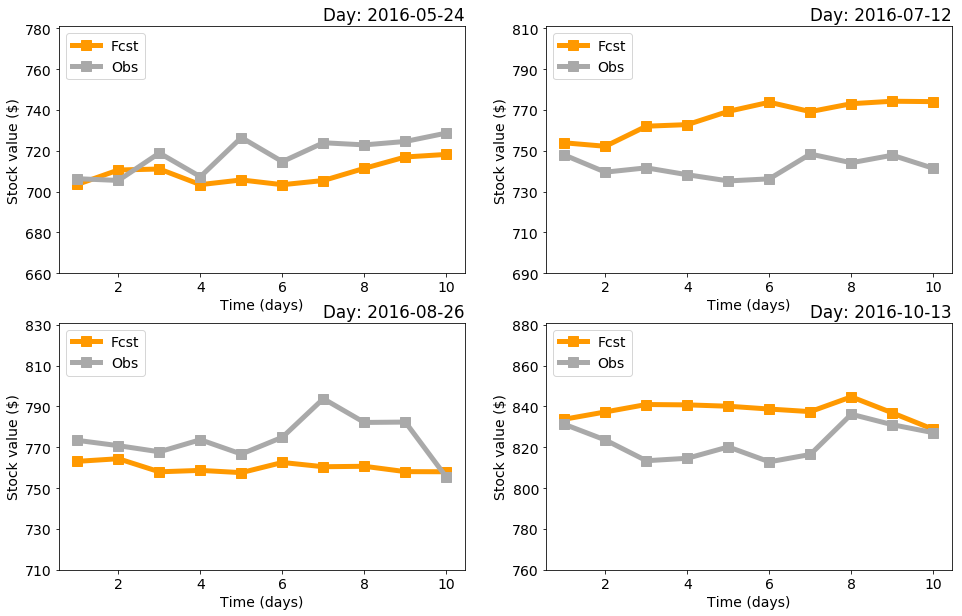

In [83]:
# Loop over each sample of test data and compare observed vs. forecasted horizons
# Note news data was not available after 7/1/2016, so only first sample uses this feature

plt.figure(0,figsize=(16,10))

for k in range(0,4):

    # Read forecasted data 
    df = pd.read_csv(StringIO(pred[k]), header=None, index_col = 0)
    fcst = df.as_matrix()

    # Read observed data
    df = pd.read_csv(f[k]) 
    odf = df[df.symbol == target]
    odf["adjclose"] = odf.close 
    odf.drop(['close','symbol'], 1, inplace=True)
    obs = odf.as_matrix()

    # Find overlaping horizons in observed data 
    lags = []
    horizons = []
    dates = []
    nsample = len(obs) - lag - horiz  
    for i in range(nsample):
        lags.append(obs[i: i + lag , -1])
        horizons.append(obs[i + lag : i + lag + horiz, -1])
        dates.append(obs[i + lag : i + lag + horiz, 0])
    lags = np.array(lags)
    horizons = np.array(horizons)
    dates = np.array(dates)
    
    # Save sample 1 references for benchmark studies
    if(k == 0): 
        fcst1 = fcst
        horizons1 = horizons
        dates1 = dates

    # Compute MAE
    s = fcst.shape
    sum = 0
    for i in range(s[0]):
        dif = abs(fcst[i,0] - horizons[0,i])
        sum += dif
    mae = sum / s[0]
    print('Sample ', k+1, ', Day of forecast: ', dates[0][0], ', MAE = ',round(mae), sep = '')

    # Plot observed vs. forecasted horizons
    xax = np.array([])
    xax = [np.append(xax,i) for i in range(1,horiz+1)]
    plt.subplot('22' + str(k+1))
    mpl.rcParams['font.size']=14
    plt.plot(xax,fcst[:],color='#FF9900',marker='s', label="Fcst",linewidth=5,markersize=10)
    plt.plot(xax,horizons[0,:],color='#A9A9A9',marker='s', label="Obs",linewidth=5,markersize=10)
    plt.xlabel('Time (days)')
    plt.ylabel('Stock value ($)')
    plt.legend(loc='upper left')
    plt.title('Day: '+ dates[0][0],loc='right')
    miny = round(min(horizons[0,:])/10)*10 - 50
    maxy = miny + 121
    plt.ylim(miny,maxy)
    plt.yticks(np.arange(miny,maxy,20))
    # plt.xticks(xax, dates)

plt.savefig('results.png')

## Performance benchmark analysis

### 1) Compare with performance of ARIMAX 

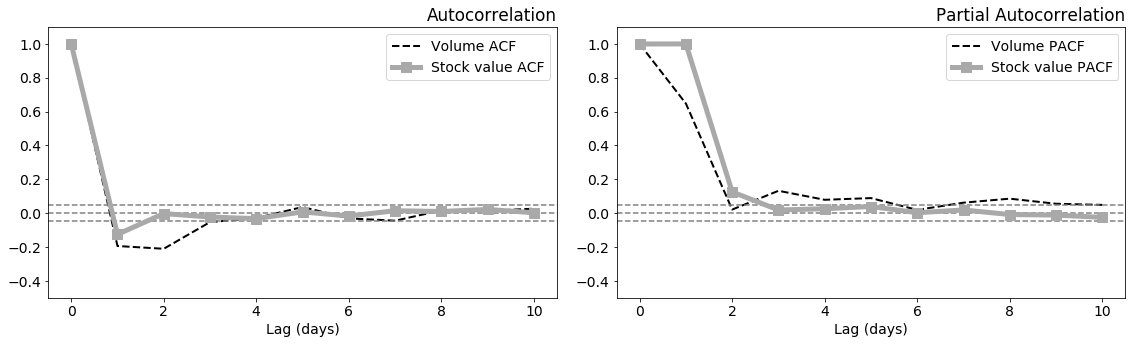

In [51]:
### Vizualize time series trends (auto-correlations)

# Let us look at the entire dataset
file = './inputdata/stockprices.csv'
d = pd.read_csv(file, index_col = 0)

# Select covariates of interest and plot ACF for each
data = d[d.symbol == target]

# Plot Auto-correlatoin and partial auto-correlation functions 
acf_clo = acf(data['close'].diff().iloc[1:], nlags=10) # check past 2 weeks
acf_vol = acf(data['volume'].diff().iloc[1:], nlags=10) 
pacf_clo = pacf(data['close'].iloc[:], nlags=10, method='ols')
pacf_vol = pacf(data['volume'].iloc[:], nlags=10, method='ols')
plt.figure(1,figsize=(16,5))

plt.subplot(121) 
plt.plot(acf_vol,linestyle='--',color='black', label="Volume ACF",linewidth=2, markersize = 5)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(data)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(data)),linestyle='--',color='gray')
plt.plot(acf_clo,color='#A9A9A9',marker='s',label="Stock value ACF",linewidth=5, markersize = 10)
plt.xlim(-0.5,10.5); plt.ylim(-0.5,1.1)
plt.xlabel('Lag (days)'); plt.legend(loc='upper right'); plt.title('Autocorrelation',loc='right')

plt.subplot(122)
plt.plot(pacf_vol,linestyle='--',color='black', label="Volume PACF",linewidth=2, markersize = 5)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(data)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(data)),linestyle='--',color='gray')
plt.plot(pacf_clo,color='#A9A9A9',marker='s',label="Stock value PACF",linewidth=5, markersize = 10)
plt.xlim(-0.5,10.5); plt.ylim(-0.5,1.1)
plt.xlabel('Lag (days)'); plt.legend(loc='upper right'); plt.title('Partial Autocorrelation',loc='right')

plt.tight_layout()
plt.savefig('./acf_pacf.png')

In [54]:
%%sh
pip install pyflux # Install pyflux that contains ARIMA with exogenous variables (ARIMAx)

You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [57]:
# Prepare the data
import pyflux as pf

# Download all data files created during training (training, test, sentiment) in current path
# Benchmarking only on first sampled time series because news data not avaiulable after 7/1/2016
trainfile = './traindata.csv'
testfile = f[0]
sentimentfile = './sentiment.csv'
d1 = pd.read_csv(trainfile, index_col = 0)
d2 = pd.read_csv(testfile, index_col = 0)
d3 = pd.read_csv(sentimentfile, index_col = 0)

# Select covariates of interest
traindata = d1[d1.symbol == target]
testdata = d2[d2.symbol == target]
for covariate in covariates: # for now it replaces covariate, so to refine later
    dummy1 = d1[d1.symbol == covariate]
    dummy2 = d2[d2.symbol == covariate]
    feat = covariate + 'close'
    traindata[feat] = dummy1['close']
    testdata[feat] = dummy2['close']    
    feat = covariate + 'volume'
    traindata[feat] = dummy1['volume']
    testdata[feat] = dummy2['volume']
    
traindata.drop(['open','low','high','symbol'], 1, inplace=True) 
testdata.drop(['open','low','high','symbol'], 1, inplace=True) 

alldata = pd.concat([traindata,testdata],axis=0) # Seems it sees the test data, but I keep it because dates were weirdly shifted in past in predict step otherwise

# Add market news sentiment data
news = d3[d3.index <= alldata.index[-1]] # test data contains just one series so need to adjust sentiment series 
full = pd.concat([alldata,news],axis=1)
news = news[news.index >= testdata.index[0]]
testdata_s = pd.concat([testdata,news],axis=1)

# Shift all covariate by horizon span to regress target on past (not future) of covariates = assume we don't know the future of covariate
print('Shifting covariate time lines, please be patient')
size = full.shape
s = size[0] - horiz
for i in range(0,s):
    for j in range(0,len(full.columns)):
        if j > 0: # Only shift covariates ('close' is in first column) 
            full.iloc[i,j] = full.iloc[i+horiz,j]  
# Delete last span since it's redundant now
full = full.iloc[0:s,:]  

size = testdata_s.shape
s = size[0] - horiz
# Shift all covariate by horizon span to regress target on past of covariate = assume we don't know the future of covariate
for i in range(0,s):
    for j in range(0,len(testdata_s.columns)):
        if j > 0: # Only shift covariates ('close' is in first column) 
            testdata_s.iloc[i,j] = testdata_s.iloc[i+horiz,j]  
# Delete last span since it's redundant now
testdata_s = testdata_s.iloc[0:s,:]  # Only keep exogenous variables for ARIMAX
print('--- Done ---')

# Grid search over hyper-parameters p, d, q
print('Grid search for ARIMA hyper-parameters (p,d,q)')
for p in range(2,6):
    for q in range(2,6):
        print('(p,q) = (', p,',',q,')',sep = '')
        d=0
        arimaxmodel = pf.ARIMAX(data=full, formula='close~1+volume+STOCKBclose+STOCKBvolume+s', 
                            ar=p, ma=q, integ=d) #, family=pf.Normal())
        results = arimaxmodel.fit("MLE")
        # results.summary()
        afcst = arimaxmodel.predict(h=horiz, oos_data=testdata_s[-horiz:]) # only exogenous variables are taken from oos_data in ARIMAx

        #print('Forecasted: ',afcst)
        #print('Observed: ', horizons[0,:])

        # Get RMSE and MAE
        s = afcst.shape
        sum = 0
        for i in range(s[0]):
            dif = abs(afcst.iloc[i,0] - horizons1[0,i])
            # print('step ',i,': ',round(dif), sep = '')
            sum += dif
        mae = sum / s[0]
        print('MAE = ',round(mae), sep = '')
print('--- Done ---')

# Re-run ARIMAx with best (p,q)
print('Produce a forecast with chosen (p,d,q)')
p=3
q=3
d=0
arimaxmodel = pf.ARIMAX(data=full, formula='close~1+volume+STOCKBclose+STOCKBvolume+s', 
                ar=p, ma=q, integ=d) #, family=pf.Normal())
results = arimaxmodel.fit("MLE")
results.summary()
afcst = arimaxmodel.predict(h=horiz, oos_data=testdata_s[-horiz:]) 
print('Forecasted: ',afcst)
print('Observed: ', horizons1[0,:])
print('--- Done ---')


Shifting covariate time lines, please be patient
--- Done ---
Grid search for ARIMA hyper-parameters (p,d,q)
(p,q) = (2,2)
MAE = 136.0
(p,q) = (2,3)
MAE = 22.0
(p,q) = (2,4)
MAE = 81.0
(p,q) = (2,5)
MAE = 120.0
(p,q) = (3,2)
MAE = 8.0
(p,q) = (3,3)
MAE = 10.0
(p,q) = (3,4)
MAE = 21.0
(p,q) = (3,5)
MAE = 66.0
(p,q) = (4,2)
MAE = 94.0
(p,q) = (4,3)
MAE = 92.0
(p,q) = (4,4)
MAE = 15.0
(p,q) = (4,5)
MAE = 35.0
(p,q) = (5,2)
MAE = 5.0
(p,q) = (5,3)
MAE = 77.0
(p,q) = (5,4)
MAE = 74.0
(p,q) = (5,5)
MAE = 23.0
--- Done ---
Produce a forecast with chosen (p,d,q)
Normal ARIMAX(3,0,3)                                                                                      
======================================================= ==================================================
Dependent Variable: close                               Method: MLE                                       
Start Date: 2010-01-07                                  Log Likelihood: -25623.4156                       
End Date: 2

### 2) Compare with performance of DeepAR 

In [74]:

# Train and deploy a DeepAR model

# Setup the DeepAR containers/paths 
containers = {'us-east-1': '522234722520.dkr.ecr.us-east-1.amazonaws.com/forecasting-deepar:latest'}
image_name = containers[boto3.Session().region_name]
s3filesystem = s3fs.S3FileSystem()
s3_data_path = 'jeremydavid1/sagemaker/data' # Replace by a valid S3 bucket name

# Prepare the data 
ts_train = full['close']
ts_train_cov = full['STOCKBclose']
ts_train_news = full['s']

# Fetch data into proper JSON strings that DeepAR can consume, then write to S3
s = ts_train.shape
lagdeep = round(s[0]/10) # DeepAR samples lag and horiz on each ts so needs length >> (lag + horiz)
def load_data(stock, lag, horiz):
    data = stock.as_matrix() 
    lags = []
    horizons = [] 
    nsample = len(data) - horiz  # len(data) - lag - horiz  # Number of time series (Number of sample in 3D)
    for i in range(0,nsample,lag): 
        lags.append(data[i: i + lag])                  
        horizons.append(data[i + lag : i + lag + horiz])    
    x_train = np.array(lags)
    y_train = np.array(horizons)
    return [x_train, y_train]

X_train, y_train = load_data(ts_train, lagdeep, horiz)
X_train_cov, y_train_cov = load_data(ts_train_cov, lagdeep, horiz)
X_train_news, y_train_news = load_data(ts_train_news, lagdeep, horiz)

def series_to_obj(ts,t,cat):
    obj = {"start": str(t), "target": list(ts), "cat": cat}
    return obj

def series_to_jsonline(ts,t,cat):
    return json.dumps(series_to_obj(ts,t,cat))

with s3filesystem.open(s3_data_path + "/train/train.json", 'wb') as fp:
    for i in range(len(X_train)): 
        fp.write(series_to_jsonline(X_train[i],ts_train.index[i],0).encode("utf-8"))     # cat = 0 for target
        fp.write('\n'.encode("utf-8"))
        fp.write(series_to_jsonline(X_train_cov[i],ts_train.index[i],1).encode("utf-8")) # cat = 1 for covariate
        fp.write('\n'.encode("utf-8"))       
        fp.write(series_to_jsonline(X_train_news[i],ts_train.index[i],2).encode("utf-8")) # cat = 1 for covariate
        fp.write('\n'.encode("utf-8"))  

with s3filesystem.open(s3_data_path + "/test/test.json", 'wb') as fp:
    for i in range(len(y_train)): 
        fp.write(series_to_jsonline(y_train[i],ts_train.index[i+lag],0).encode("utf-8"))
        fp.write('\n'.encode("utf-8"))
        fp.write(series_to_jsonline(y_train_cov[i],ts_train.index[i+lag],1).encode("utf-8"))
        fp.write('\n'.encode("utf-8"))
        fp.write(series_to_jsonline(y_train_news[i],ts_train.index[i+lag],2).encode("utf-8"))
        fp.write('\n'.encode("utf-8"))
        
# Define DeepAR estimator
estimator = sage.estimator.Estimator(
    sagemaker_session=sess,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c4.xlarge',
    base_job_name='DeeparFinance',
    output_path="s3://" + s3_data_path
)

# Define hyperparameters
freq = 'D'
prediction_length = horiz
context_length = lag

hyperparameters = {
    "time_freq": freq,
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
    "cardinality": 3,
    "embedding_dimension": 10,
    "num_cells": "100",
    "num_layers": "5",
    "likelihood": "gaussian",
    "epochs": "100",
    "mini_batch_size": "32",
    "learning_rate": "0.001",
    "dropout_rate": "0.1",
    "early_stopping_patience": "10"
}
estimator.set_hyperparameters(**hyperparameters)

# Train the model
data_channels = {
    "train": "s3://{}/train/".format(s3_data_path),
    "test": "s3://{}/test/".format(s3_data_path)
}
estimator.fit(inputs=data_channels)


# Deploy the DeepAR model
job_name = estimator.latest_training_job.name
endpoint_name = sess.endpoint_from_job(
    job_name=job_name,
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    deployment_image=image_name,
    role=role
)


INFO:sagemaker:Creating training-job with name: DeeparFinance-2018-07-26-23-21-04-610


...............................................
Arguments: train
[07/26/2018 23:24:52 INFO 139979114559296] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_patience': u''}
[07/26/2018 23:24:52 INFO 139979114559296] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'dropout_rate': u'0.1', u'mini_batch_size': u'32', u'learning_rate': u'0.001', u'num_layers': u'5', u'prediction_length': u'10', u'epochs': u'100', u'embedding_dimension': u'10', u'tim

[07/26/2018 23:25:01 INFO 139979114559296] Epoch[4] Batch[10] avg_epoch_loss=4.759077
[07/26/2018 23:25:01 INFO 139979114559296] Epoch[4] Batch [10]#011Speed: 243.47 samples/sec#011loss=4.197068
[07/26/2018 23:25:01 INFO 139979114559296] processed a total of 341 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1563.6169910430908, "sum": 1563.6169910430908, "min": 1563.6169910430908}}, "EndTime": 1532647501.06988, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1532647499.50621}

[07/26/2018 23:25:01 INFO 139979114559296] #throughput_metric: host=algo-1, train throughput=218.069167617 records/second
[07/26/2018 23:25:01 INFO 139979114559296] #progress_metric: host=algo-1, completed 5 % of epochs
[07/26/2018 23:25:01 INFO 139979114559296] loss did not improve for 1 epochs
[07/26/2018 23:25:01 INFO 139979114559296] Epoch[5] Batch[0] avg_epoch_loss=4.442435
[07/26/2018 23:25:01 INFO 139979114559296] Epoch[5] Batch[5] avg_e

[07/26/2018 23:25:11 INFO 139979114559296] processed a total of 317 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1387.4170780181885, "sum": 1387.4170780181885, "min": 1387.4170780181885}}, "EndTime": 1532647511.045148, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1532647509.657648}

[07/26/2018 23:25:11 INFO 139979114559296] #throughput_metric: host=algo-1, train throughput=228.461551335 records/second
[07/26/2018 23:25:11 INFO 139979114559296] #progress_metric: host=algo-1, completed 12 % of epochs
[07/26/2018 23:25:11 INFO 139979114559296] best epoch loss so far
[07/26/2018 23:25:11 INFO 139979114559296] Saved checkpoint to "/opt/ml/model/state_98effd82-8f09-4659-b797-58633b55b460-0000.params"
#metrics {"Metrics": {"state.serialize.time": {"count": 1, "max": 20.843982696533203, "sum": 20.843982696533203, "min": 20.843982696533203}}, "EndTime": 1532647511.066588, "Dimensions": {"Host": "algo-1", "Operation": "t

[07/26/2018 23:25:20 INFO 139979114559296] processed a total of 304 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1367.4030303955078, "sum": 1367.4030303955078, "min": 1367.4030303955078}}, "EndTime": 1532647520.912216, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1532647519.544491}

[07/26/2018 23:25:20 INFO 139979114559296] #throughput_metric: host=algo-1, train throughput=222.304121524 records/second
[07/26/2018 23:25:20 INFO 139979114559296] #progress_metric: host=algo-1, completed 19 % of epochs
[07/26/2018 23:25:20 INFO 139979114559296] loss did not improve for 6 epochs
[07/26/2018 23:25:21 INFO 139979114559296] Epoch[19] Batch[0] avg_epoch_loss=3.310697
[07/26/2018 23:25:21 INFO 139979114559296] Epoch[19] Batch[5] avg_epoch_loss=3.544168
[07/26/2018 23:25:21 INFO 139979114559296] Epoch[19] Batch [5]#011Speed: 249.54 samples/sec#011loss=3.544168
[07/26/2018 23:25:22 INFO 139979114559296] Epoch[19] Batch[10]

[07/26/2018 23:25:31 INFO 139979114559296] processed a total of 318 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1366.3330078125, "sum": 1366.3330078125, "min": 1366.3330078125}}, "EndTime": 1532647531.258592, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1532647529.891904}

[07/26/2018 23:25:31 INFO 139979114559296] #throughput_metric: host=algo-1, train throughput=232.71676395 records/second
[07/26/2018 23:25:31 INFO 139979114559296] #progress_metric: host=algo-1, completed 26 % of epochs
[07/26/2018 23:25:31 INFO 139979114559296] best epoch loss so far
[07/26/2018 23:25:31 INFO 139979114559296] Saved checkpoint to "/opt/ml/model/state_b830770b-682c-4393-91cd-5f438c19fd99-0000.params"
#metrics {"Metrics": {"state.serialize.time": {"count": 1, "max": 31.18586540222168, "sum": 31.18586540222168, "min": 31.18586540222168}}, "EndTime": 1532647531.290328, "Dimensions": {"Host": "algo-1", "Operation": "training", "Al

[07/26/2018 23:25:46 INFO 139979114559296] Epoch[35] Batch[10] avg_epoch_loss=3.207572
[07/26/2018 23:25:46 INFO 139979114559296] Epoch[35] Batch [10]#011Speed: 249.42 samples/sec#011loss=3.239900
[07/26/2018 23:25:46 INFO 139979114559296] processed a total of 329 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1486.9539737701416, "sum": 1486.9539737701416, "min": 1486.9539737701416}}, "EndTime": 1532647546.189548, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1532647544.702303}

[07/26/2018 23:25:46 INFO 139979114559296] #throughput_metric: host=algo-1, train throughput=221.239526593 records/second
[07/26/2018 23:25:46 INFO 139979114559296] #progress_metric: host=algo-1, completed 36 % of epochs
[07/26/2018 23:25:46 INFO 139979114559296] loss did not improve for 2 epochs
[07/26/2018 23:25:46 INFO 139979114559296] Epoch[36] Batch[0] avg_epoch_loss=3.643813
[07/26/2018 23:25:47 INFO 139979114559296] Epoch[36] Batch[5

[07/26/2018 23:25:56 INFO 139979114559296] processed a total of 311 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1368.332862854004, "sum": 1368.332862854004, "min": 1368.332862854004}}, "EndTime": 1532647556.320938, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1532647554.952291}

[07/26/2018 23:25:56 INFO 139979114559296] #throughput_metric: host=algo-1, train throughput=227.268593053 records/second
[07/26/2018 23:25:56 INFO 139979114559296] #progress_metric: host=algo-1, completed 43 % of epochs
[07/26/2018 23:25:56 INFO 139979114559296] loss did not improve for 4 epochs
[07/26/2018 23:25:56 INFO 139979114559296] Epoch[43] Batch[0] avg_epoch_loss=3.089889
[07/26/2018 23:25:57 INFO 139979114559296] Epoch[43] Batch[5] avg_epoch_loss=3.097956
[07/26/2018 23:25:57 INFO 139979114559296] Epoch[43] Batch [5]#011Speed: 238.18 samples/sec#011loss=3.097956
[07/26/2018 23:25:57 INFO 139979114559296] Epoch[43] Batch[10] av

[07/26/2018 23:26:16 INFO 139979114559296] Epoch[56] Batch[5] avg_epoch_loss=3.072548
[07/26/2018 23:26:16 INFO 139979114559296] Epoch[56] Batch [5]#011Speed: 247.25 samples/sec#011loss=3.072548
[07/26/2018 23:26:16 INFO 139979114559296] processed a total of 317 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1380.4230690002441, "sum": 1380.4230690002441, "min": 1380.4230690002441}}, "EndTime": 1532647576.582002, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1532647575.201531}

[07/26/2018 23:26:16 INFO 139979114559296] #throughput_metric: host=algo-1, train throughput=229.621619755 records/second
[07/26/2018 23:26:16 INFO 139979114559296] #progress_metric: host=algo-1, completed 57 % of epochs
[07/26/2018 23:26:16 INFO 139979114559296] loss did not improve for 1 epochs
[07/26/2018 23:26:16 INFO 139979114559296] Epoch[57] Batch[0] avg_epoch_loss=2.791850
[07/26/2018 23:26:17 INFO 139979114559296] Epoch[57] Batch[5] 

[07/26/2018 23:26:31 INFO 139979114559296] processed a total of 303 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1374.3329048156738, "sum": 1374.3329048156738, "min": 1374.3329048156738}}, "EndTime": 1532647591.067807, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1532647589.693153}

[07/26/2018 23:26:31 INFO 139979114559296] #throughput_metric: host=algo-1, train throughput=220.450980879 records/second
[07/26/2018 23:26:31 INFO 139979114559296] #progress_metric: host=algo-1, completed 67 % of epochs
[07/26/2018 23:26:31 INFO 139979114559296] loss did not improve for 8 epochs
[07/26/2018 23:26:31 INFO 139979114559296] Epoch[67] Batch[0] avg_epoch_loss=3.359209
[07/26/2018 23:26:31 INFO 139979114559296] Epoch[67] Batch[5] avg_epoch_loss=3.094839
[07/26/2018 23:26:31 INFO 139979114559296] Epoch[67] Batch [5]#011Speed: 243.54 samples/sec#011loss=3.094839
[07/26/2018 23:26:32 INFO 139979114559296] processed a total o

INFO:sagemaker:Creating model with name: DeeparFinance-2018-07-26-23-21-04-610


===== Job Complete =====
Billable seconds: 219


INFO:sagemaker:Creating endpoint-config with name DeeparFinance-2018-07-26-23-21-04-610
INFO:sagemaker:Creating endpoint with name DeeparFinance-2018-07-26-23-21-04-610


---------------------------------------------------------------!

In [75]:
# Use the DeepAR model to forecast future trends of stock values

# Create a pandas series format (= list of df)
time_series = []
temp = d2[d2.symbol == target]
data = temp[temp.index < '2016-06-05']
t0 = str(data.index[0]) 
print(t0)
print(data.index[-1])
data.drop(['open','low','high','symbol'], 1, inplace=True) 
s = data.shape
index = pd.DatetimeIndex(start=t0, freq=freq, periods=s[0])
time_series.append(pd.Series(data=data['close'].tolist(), index=index))

# To build a prediction request to the endpoint we'll just adapt the utility class provided in the original 
# AWS SageMaker DeepAR sample notebook (needs input in pandas series format instead of json string)

class DeepARPredictor(sage.predictor.RealTimePredictor):

    def set_prediction_parameters(self, freq, prediction_length):
        self.freq = freq
        self.prediction_length = prediction_length
        
    def predict(self, ts, cat=None, encoding="utf-8", num_samples=100, quantiles=["0.1", "0.5", "0.9"]):
        prediction_times = [x.index[-1]+1 for x in ts]
        req = self.__encode_request(ts, cat, encoding, num_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, prediction_times, encoding)
    
    def __encode_request(self, ts, cat, encoding, num_samples, quantiles):
        instances = [series_to_obj(ts[k], ts[k].index[0], cat) for k in range(len(ts))]
        configuration = {"num_samples": num_samples, "output_types": ["quantiles"], "quantiles": quantiles}
        http_request_data = {"instances": instances, "configuration": configuration}
        return json.dumps(http_request_data).encode(encoding)
    
    def __decode_response(self, response, prediction_times, encoding):
        response_data = json.loads(response.decode(encoding))
        list_of_df = []
        for k in range(len(prediction_times)):
            prediction_index = pd.DatetimeIndex(start=prediction_times[k], freq=self.freq, periods=self.prediction_length)
            list_of_df.append(pd.DataFrame(data=response_data['predictions'][k]['quantiles'], index=prediction_index))
        return (list_of_df, response_data)

predictor = DeepARPredictor(
    endpoint=endpoint_name,
    sagemaker_session=sess,
    content_type="application/json"
)
predictor.set_prediction_parameters(freq, prediction_length)

# Forecasting
#X_test = testdata['close']
#print(time_series_training)
results,jsonform = predictor.predict(time_series,0) # cat = 0 for target
dfcst = jsonform['predictions'][0]['quantiles']['0.5']
print('Forecasted: ',dfcst)
print('Observed: ', horizons1[0,:])


2016-04-22
2016-06-03
Forecasted:  [701.680480957, 718.9865722656, 718.7622680664, 717.1608886719, 714.1392822266, 715.6391601562, 713.3333740234, 712.115234375, 714.0823974609, 707.2515258789]
Observed:  [706.3216189658151 705.4624399659621 718.8932927601668 707.2947926159261
 726.4835317756862 714.6745181486232 723.9255701536003 722.8790451892575
 724.5534665133741 728.6536240571036]


### 3) Vizualize results from all methods together

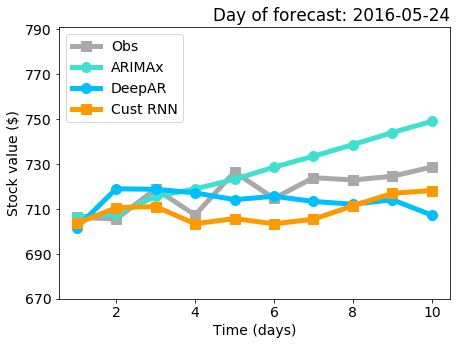

In [84]:
# Plot observed and predicted horizons for all benchmarked methods
xax = np.array([]); xax = [np.append(xax,i) for i in range(1,horiz+1)]
plt.figure(1,figsize=(7,5))
mpl.rcParams['font.size']=14
plt.plot(xax,horizons1[0,:],color='#A9A9A9',marker='s', label="Obs",linewidth=5,markersize=10) 
plt.plot(xax, afcst,color='#40E0D0',marker='o',label="ARIMAx",linewidth=5,markersize=10)
plt.plot(xax, dfcst,color='#00BFFF',marker='o',label="DeepAR",linewidth=5,markersize=10)
plt.plot(xax,fcst1[:],color='#FF9900',marker='s', label="Cust RNN",linewidth=5,markersize=10)
plt.xlabel('Time (days)')
plt.ylabel('Stock value ($)')
plt.legend(loc='upper left')
plt.title('Day of forecast: '+ dates1[0][0],loc='right')
miny = round(min(horizons1[0,:])/10)*10 - 40
maxy = miny + 121
plt.ylim(miny,maxy)
plt.yticks(np.arange(miny,maxy,20))
plt.savefig('benchmarks.png')

## Delete Endpoint 

In [227]:
# Delete endpoint
sess.delete_endpoint(predictor.endpoint)

INFO:sagemaker:Deleting endpoint with name: rnn-forecast006-2018-04-20-19-08-28-477
